In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"
import keras
from keras import layers
import numpy as np
import xarray as xr
import zarr
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import random
import jax
import tensorflow as tf
from tqdm import tqdm
import jax.numpy as jnp
from jax import grad, jit, vmap
from utils.utils import ClimateDownscalingLossJAX

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
jax.config.update('jax_enable_x64', True)
jax.random.PRNGKey(SEED)


# Set the working directory
os.chdir('/data/keeling/a/ad87/downscale')

2024-10-26 19:44:58.439474: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1729989898.481754   93528 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1729989898.488669   93528 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-26 19:45:01.186852: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.6.77). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


#### Data Handling: Load and Resample Data
We will load the CMIP6 data and the GMFD observational data. We’ll resample the GMFD data to the CMIP6 resolution (e.g., ~100 km) to use as the target during training.



In [2]:
# Load the CMIP6 raw data (predictor variables)
cmip6_data_path = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/historical/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr'
cmip6_data = xr.open_zarr(cmip6_data_path)

# Load the GMFD reference observational data (target variable)
gmfd_data_path = '/data/keeling/a/cristi/a/downscaled_data/gmfd/ncs/ro'
gmfd_files = [f'{gmfd_data_path}/tas_daily_ro_{year}.nc' for year in range(1950, 2015)]
gmfd_data = xr.open_mfdataset(gmfd_files, combine='by_coords')

# Resample  CMIP6 to GMFD resolution (~25 km)
target_lat = gmfd_data.lat
target_lon = gmfd_data.lon
cmip6_high_res = cmip6_data.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})


# Normalize the data (standardization)
def normalize(data):
    mean = data.mean().compute().item()
    std = data.std().compute().item()
    return (data - mean) / std

cmip6_data_norm = normalize(cmip6_high_res['tas'])
gmfd_data_norm = normalize(gmfd_data['tas'])

# Convert data to NumPy arrays for use in Keras
cmip6_train = cmip6_data_norm.values
gmfd_train = gmfd_data_norm.values

#### Build the CNN Model (Keras with JAX Backend)
Now let's define a simple CNN model using Keras with JAX backend. Our model will take the coarse-resolution CMIP6 data and predict the high-resolution GMFD data.



In [3]:
import keras
from keras import layers
import numpy as np
import jax
import jax.numpy as jnp

# Define the model architecture (as done earlier)
n = 32  # base filter count
input_shape = (cmip6_train.shape[1], cmip6_train.shape[2], 1)  # Assuming 1 channel (tas)

def climate_cnn(input_shape):
    inputs = keras.Input(shape=input_shape)
    
    # Encoder with convolutional layers
    x = inputs
    skip_connections = []

    # 31 convolutional layers, with filter numbers n, 2n, 4n and batch normalization
    for i in range(31):
        filters = n if i < 10 else (2 * n if i < 20 else 4 * n)
        x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        if i % 2 == 1:  # Every 2 convolutional layers, save skip connection
            skip_connections.append(x)

    # Decoder with upsampling layers and skip connections
    for i in range(16):
        filters = 4 * n if i < 6 else (2 * n if i < 12 else n)
        x = layers.Conv2DTranspose(filters, kernel_size=3, strides=1, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        
        if i < len(skip_connections):
            skip_connection = skip_connections[-(i + 1)]
            if skip_connection.shape[-1] != x.shape[-1]:  # Align the number of channels
                skip_connection = layers.Conv2D(filters, kernel_size=1, strides=1, padding='same')(skip_connection)
            x = layers.Add()([x, skip_connection])

    # Final convolutional layer without activation
    outputs = layers.Conv2D(1, kernel_size=1, strides=1, padding='same')(x)
    
    # Building the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Build and compile model
model = climate_cnn(input_shape)


#### Split the data
Train set: The first portion of the time period (e.g., 60-70% of the time series).
Validation set: The next portion of the time series (e.g., the following 15-20% of the time series).
Test set: The final portion of the time series (e.g., the last 15-20%): 

In [4]:

# Reshape data to add the channel dimension
cmip6_train_reshaped = cmip6_train[..., np.newaxis]
gmfd_train_reshaped = gmfd_train[..., np.newaxis]

# Get the total number of time steps
n_samples = cmip6_train_reshaped.shape[0]

# Split indices based on time series order
train_size = int(n_samples * 0.6)  # 60% for training
val_size = int(n_samples * 0.2)    # 20% for validation
test_size = n_samples - train_size - val_size  # Remainder for test
print(train_size, val_size, test_size)

# Split the data while preserving the temporal structure
X_train = cmip6_train_reshaped[:train_size]
y_train = gmfd_train_reshaped[:train_size]

X_val = cmip6_train_reshaped[train_size:train_size + val_size]
y_val = gmfd_train_reshaped[train_size:train_size + val_size]

X_test = cmip6_train_reshaped[train_size + val_size:]
y_test = gmfd_train_reshaped[train_size + val_size:]


14244 4748 4749


#### Train the model

In [7]:
input_shape = (cmip6_train.shape[1], cmip6_train.shape[2], 1)  # Assuming 1 channel (tas)
model = climate_cnn(input_shape)

# Initialize the custom loss function
climate_loss = ClimateDownscalingLossJAX()

# Training settings
epochs = 1500
batch_size = 32

# Compile model with refined custom loss
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, 
              loss=climate_loss,
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=10,
        min_lr=1e-6
    ),
    keras.callbacks.ModelCheckpoint(
        'models/cnn_best_model.keras',
        monitor='val_loss',
        save_best_only=True
    )
]

# Calculate the total number of batches
total_batches = int(np.ceil(len(X_train) / batch_size) * epochs)

# Initialize the history object
history = {'loss': [], 'val_loss': []}

# Using a single progress bar for the entire training process
with tqdm(total=total_batches, desc='Training', unit='batch') as pbar:
    # Fit the model using the fit method with callbacks and progress reporting
    for epoch in range(epochs):
        # Fit the model for one epoch
        history_epoch = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=1,  # Train for one epoch
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=0  # Suppress output
        )
        
        # Update history
        history['loss'].append(history_epoch.history['loss'][0])
        history['val_loss'].append(history_epoch.history['val_loss'][0])
        
        # Update progress bar with useful information
        pbar.set_postfix({
            'epoch': epoch + 1,
            'loss': f"{history['loss'][-1]:.4f}",
            'val_loss': f"{history['val_loss'][-1]:.4f}"
        })
        
        # Update progress bar for the number of batches in the epoch
        pbar.update(int(np.ceil(len(X_train) / batch_size)))
        
        # Check for early stopping
        if len(history['val_loss']) > 10:  # Only check if we have enough data
            if min(history['val_loss'][-10:]) == history['val_loss'][-10]:  # If no improvement
                break

# Finalize training
print("Training completed.")


Training:   3%|▊                             | 18286/669000 [28:48<17:05:22, 10.58batch/s, epoch=41, loss=0.1412, val_loss=0.1782]

Training completed.


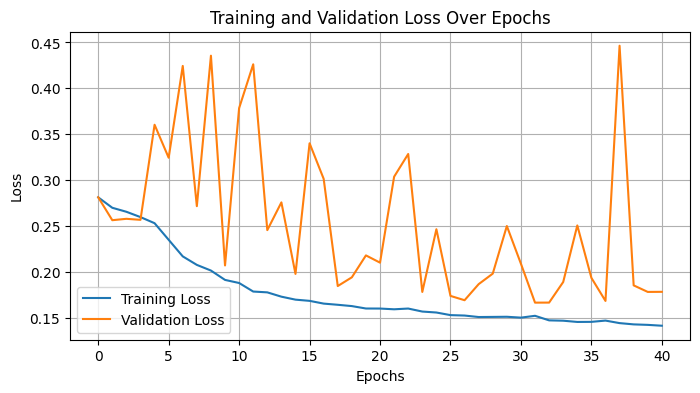

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

#### Evaluate the model on validation data

149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step


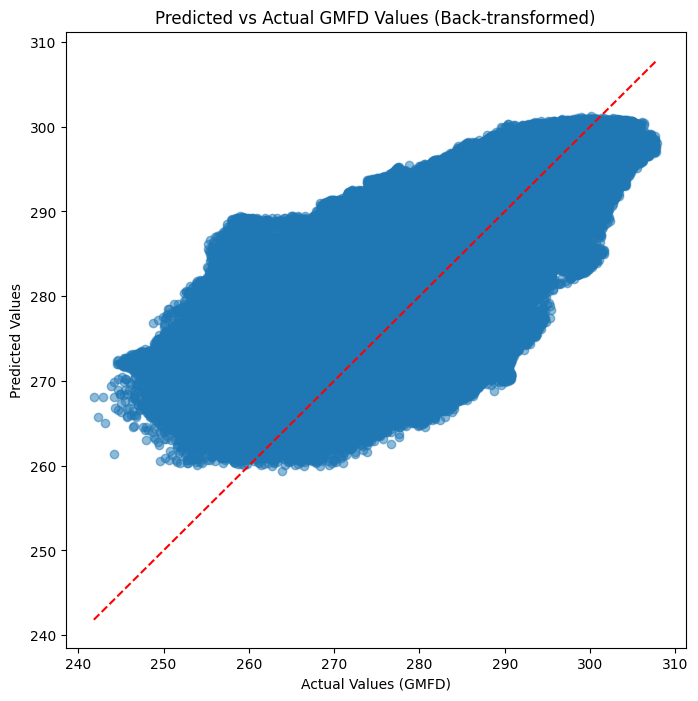

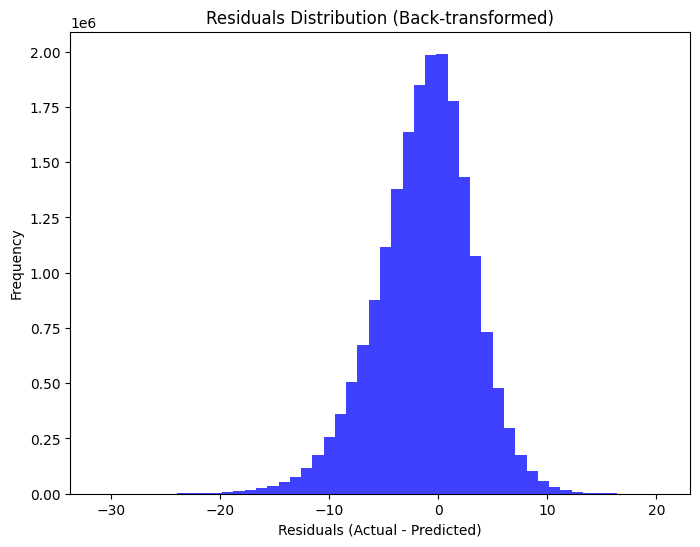

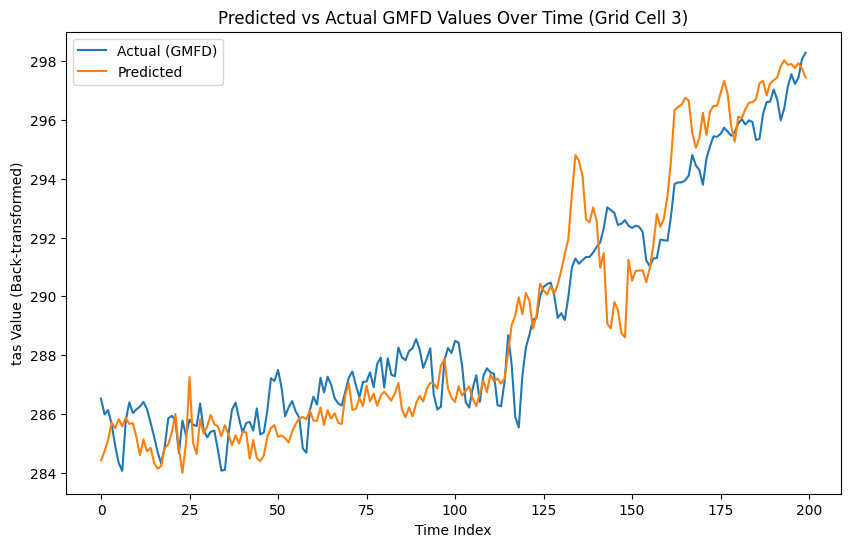

In [10]:
import numpy as np

# Back-transform function
def denormalize(data, mean, std):
    return (data * std) + mean

# Get the mean and std from the training set for denormalization
cmip6_high_res_mean = cmip6_high_res['tas'].mean().values
cmip6_high_res_std = cmip6_high_res['tas'].std().values

# Get the mean and std from the training set for denormalization
gmfd_mean = gmfd_data['tas'].mean().values
gmfd_std = gmfd_data['tas'].std().values

# Generate predictions on validation data
y_pred = model.predict(X_val)


# Back-transform the predictions for evaluation
y_val_denorm = denormalize(y_val, cmip6_high_res_mean, cmip6_high_res_std)
y_pred_denorm = denormalize(y_pred, cmip6_high_res_mean, cmip6_high_res_std)

# Plot: Predicted vs Actual Values (back-transformed)
plt.figure(figsize=(8, 8))
plt.scatter(y_val_denorm.flatten(), y_pred_denorm.flatten(), alpha=0.5)
plt.xlabel('Actual Values (GMFD)')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual GMFD Values (Back-transformed)')
plt.plot([y_val_denorm.min(), y_val_denorm.max()], [y_val_denorm.min(), y_val_denorm.max()], 'r--')  # Line of perfect prediction
plt.show()

# Plot: Residuals (Actual - Predicted) after back-transform
residuals_denorm = y_val_denorm.flatten() - y_pred_denorm.flatten()
plt.figure(figsize=(8, 6))
plt.hist(residuals_denorm, bins=50, alpha=0.75, color='blue')
plt.title('Residuals Distribution (Back-transformed)')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()

# Plot: Predicted and Actual Values Over Time for a Specific Grid Cell (Back-transformed)
# Select a grid cell (e.g., the first one)
grid_cell_index = 3
plt.figure(figsize=(10, 6))
plt.plot(y_val_denorm[:200, grid_cell_index, 0].flatten(), label='Actual (GMFD)')
plt.plot(y_pred_denorm[:200, grid_cell_index, 0].flatten(), label='Predicted')
plt.xlabel('Time Index')
plt.ylabel('tas Value (Back-transformed)')
plt.title(f'Predicted vs Actual GMFD Values Over Time (Grid Cell {grid_cell_index})')
plt.legend()
plt.show()


#### Train the Best Model on All Data
Train the model on all the data (no splitting)

In [11]:
input_shape = (cmip6_train.shape[1], cmip6_train.shape[2], 1)  # Assuming 1 channel (tas)
model = climate_cnn(input_shape)

# Compile model with refined custom loss
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, 
              loss=climate_loss,
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

# Initialize the history object
history = {'loss': [], 'val_loss': []}

# Using a single progress bar for the entire training process
with tqdm(total=total_batches, desc='Training', unit='batch') as pbar:
    # Fit the model using the fit method with callbacks and progress reporting
    for epoch in range(epochs):
        # Fit the model for one epoch
        history_epoch = model.fit(
           cmip6_train_reshaped, gmfd_train_reshaped,
            validation_data=(X_val, y_val),
            epochs=1,  # Train for one epoch
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=0  # Suppress output
        )
        
        # Update history
        history['loss'].append(history_epoch.history['loss'][0])
        history['val_loss'].append(history_epoch.history['val_loss'][0])
        
        # Update progress bar with useful information
        pbar.set_postfix({
            'epoch': epoch + 1,
            'loss': f"{history['loss'][-1]:.4f}",
            'val_loss': f"{history['val_loss'][-1]:.4f}"
        })
        
        # Update progress bar for the number of batches in the epoch
        pbar.update(int(np.ceil(len(X_train) / batch_size)))
        
        # Check for early stopping
        if len(history['val_loss']) > 10:  # Only check if we have enough data
            if min(history['val_loss'][-10:]) == history['val_loss'][-10]:  # If no improvement
                break

# Finalize training
print("Training completed.")
model.save('models/cnn_CNRM-ESM2-1.keras')  # keras format


Training:   3%|▉                             | 21408/669000 [53:28<26:57:25,  6.67batch/s, epoch=48, loss=0.1303, val_loss=0.1440]


Training completed.


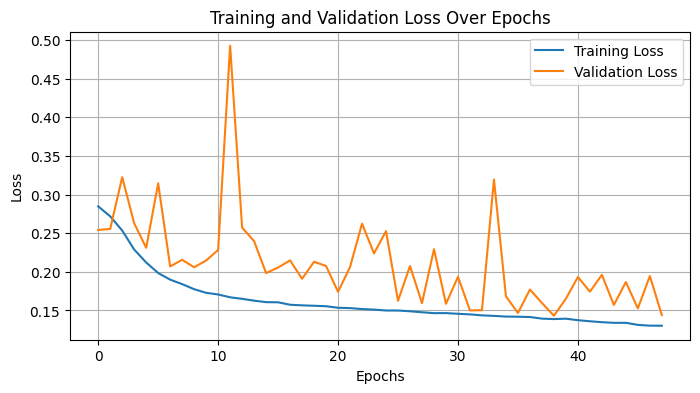

In [14]:
plt.figure(figsize=(8, 4))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

#### Apply the Model to CMIP6 Data to Downscale to GMFD Original Resolution
Now we take the coarse CMIP6 data and downscale it to the original GMFD resolution


In [12]:
# Load the model
from keras.models import load_model
#model = load_model('models/cnn_encoder_decoder.keras')

# Predict downscaled high-resolution data
predicted_high_res = model.predict(cmip6_train_reshaped)

742/742 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step


#### Post-process the Predictions

In [13]:
# Inverse transform the predictions to get the actual temperature values


# Get the mean and std from the training set for denormalization
cmip6_high_res_mean = cmip6_high_res['tas'].mean().values
cmip6_high_res_std = cmip6_high_res['tas'].std().values


# Back-transform the predictions and actual values
predicted_high_res_denorm = denormalize(predicted_high_res, cmip6_high_res_mean, cmip6_high_res_std)

# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm.reshape(gmfd_train.shape)

# Save the predictions to a NetCDF file
predicted_ds = xr.DataArray(predicted_high_res_final, dims=gmfd_data.dims, coords=gmfd_data.coords, name='tas_downscaled')
predicted_ds.to_netcdf('/data/keeling/a/ad87/downscale/ncs/cnn/predicted_high_res_tas_encod_v02.nc')

# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")

Downscaled high-resolution predictions saved to NetCDF format.


#### Scenario data

In [5]:
# Load the CMIP6 raw data (predictor variables)
cmip6_ssp245 = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp245/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_ssp245_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_ssp245 = xr.open_zarr(cmip6_ssp245)
cmip6_sp245_high_res = cmip6_ssp245.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_sp245_norm = normalize(cmip6_sp245_high_res['tas'])
# Reshape data to add the channel dimension
cmip6_sp245_reshaped = cmip6_sp245_norm.values[..., np.newaxis]
cmip6_sp245_reshaped.shape


(31411, 42, 97, 1)

#### Perform the predictions on scenario data

In [10]:
# Load the model
from keras.models import load_model
model_saved = load_model(
    'models/cnn_CNRM-ESM2-1.keras',
    custom_objects={'ClimateDownscalingLossJAX': ClimateDownscalingLossJAX}
)
# Predict downscaled high-resolution data
predicted_high_res = model_saved.predict(cmip6_sp245_reshaped)

# Get the mean and std from the training set for denormalization
cmip6_sp245_reshaped_mean = cmip6_sp245_high_res['tas'].mean().values
cmip6_sp245_reshaped_std = cmip6_sp245_high_res['tas'].std().values

# Back-transform function
def denormalize(data, mean, std):
    return (data * std) + mean
# Back-transform the predictions and actual values
predicted_high_res_denorm = denormalize(predicted_high_res, cmip6_sp245_reshaped_mean,cmip6_sp245_reshaped_std)




982/982 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step


In [11]:
predicted_high_res_final = predicted_high_res_denorm.reshape(cmip6_sp245_norm.values.shape)

# Save the predictions to a NetCDF file
predicted_ds = xr.DataArray(predicted_high_res_final, dims=cmip6_sp245_norm.dims, coords=cmip6_sp245_norm.coords, name='tas_downscaled')
predicted_ds.to_netcdf('/data/keeling/a/ad87/downscale/ncs/cnn/predicted_high_res_tas_encod_ssp245.nc')

# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")

Downscaled high-resolution predictions saved to NetCDF format.


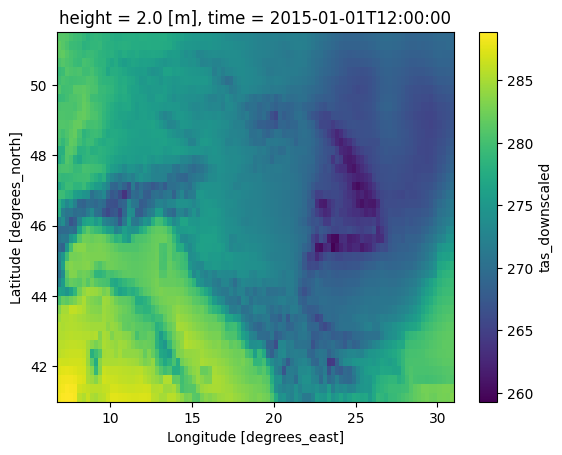

In [12]:
#Select the first time step
first_time_step = predicted_ds.isel(time=0).compute()  # Use .compute() if using Dask
first_time_step.plot()

pentru estimare model scenarii

In [8]:
import jax.numpy as jnp
from keras.saving import register_keras_serializable
from jax import jit

@register_keras_serializable()
class ClimateDownscalingLossJAX:
    def __init__(self, spatial_weight=0.3, gradient_weight=0.3, extreme_weight=0.4):
        self.spatial_weight = spatial_weight
        self.gradient_weight = gradient_weight
        self.extreme_weight = extreme_weight
        
        # JIT-compile the loss computation
        self.compute_loss = jit(self._compute_loss)
        
    def _spatial_gradients(self, x):
        dy = x[:, 1:, :] - x[:, :-1, :]
        dx = x[:, :, 1:] - x[:, :, :-1]
        return dy, dx
    
    def _spatial_gradient_loss(self, y_true, y_pred):
        dy_true, dx_true = self._spatial_gradients(y_true)
        dy_pred, dx_pred = self._spatial_gradients(y_pred)
        
        gradient_diff_y = jnp.mean(jnp.abs(dy_true - dy_pred))
        gradient_diff_x = jnp.mean(jnp.abs(dx_true - dx_pred))
        
        return gradient_diff_y + gradient_diff_x
    
    def _extreme_values_loss(self, y_true, y_pred):
        std_true = jnp.std(y_true)
        mean_true = jnp.mean(y_true)
        
        weights = jnp.where(
            jnp.abs(y_true - mean_true) > 1.5 * std_true,
            2.0,
            1.0
        )
        
        return jnp.mean(weights * jnp.square(y_true - y_pred))
    
    def _compute_loss(self, y_true, y_pred):
        mse_loss = jnp.mean(jnp.square(y_true - y_pred))
        spatial_loss = self._spatial_gradient_loss(y_true, y_pred)
        extreme_loss = self._extreme_values_loss(y_true, y_pred)
        
        delta = 1.0
        huber_loss = jnp.mean(
            jnp.where(
                jnp.abs(y_true - y_pred) < delta,
                0.5 * jnp.square(y_true - y_pred),
                delta * (jnp.abs(y_true - y_pred) - 0.5 * delta)
            )
        )
        
        total_loss = (
            (1.0 - self.spatial_weight - self.gradient_weight - self.extreme_weight) * mse_loss +
            self.spatial_weight * spatial_loss +
            self.gradient_weight * huber_loss +
            self.extreme_weight * extreme_loss
        )
        
        return total_loss

    def __call__(self, y_true, y_pred):
        return self.compute_loss(y_true, y_pred)

    def get_config(self):
        return {
            'spatial_weight': self.spatial_weight,
            'gradient_weight': self.gradient_weight,
            'extreme_weight': self.extreme_weight
        }

    @classmethod
    def from_config(cls, config):
        # Create an instance of the class using the provided configuration
        return cls(**config)  # Unpacking the config dictionary to initialize the class